In [1]:
from pathlib import Path

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

DATA_PATH = Path("../../data")

In [2]:
rng = np.random.default_rng(seed=12)
az.style.use("arviz-white")

In [3]:
kidiq = pd.read_csv(DATA_PATH / "kidiq.csv")
kidiq.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1,121.117529,4,27
1,98,1,89.361882,4,25
2,85,1,115.443165,4,27
3,83,1,99.449639,3,25
4,115,1,92.745710,4,27


## A single predictor
### A single binary predictor

In [4]:
model_1 = bmb.Model("kid_score ~ mom_hs", data=kidiq)
idata_1 = model_1.fit()
az.summary(idata_1, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kid_score_sigma, Intercept, mom_hs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,77.552,2.130,73.627,81.545
mom_hs,11.791,2.371,7.309,16.157
kid_score_sigma,19.886,0.676,18.673,21.184


### A single continuous predictor

In [5]:
model_2 = bmb.Model("kid_score ~ mom_iq", data=kidiq)
idata_2 = model_2.fit()
az.summary(idata_2, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kid_score_sigma, Intercept, mom_iq]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,25.646,5.921,15.310,37.783
mom_iq,0.612,0.059,0.504,0.727
kid_score_sigma,18.312,0.627,17.109,19.448


### Displaying a regression line as a function of one input variable

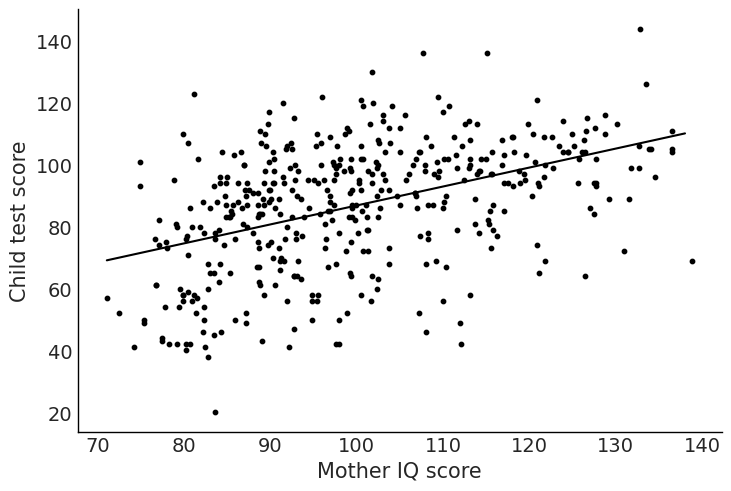

In [6]:
stats_2 = az.summary(idata_2, kind="stats")["mean"]
x = np.arange(kidiq["mom_iq"].min(), kidiq["mom_iq"].max())
y_pred = stats_2["Intercept"] + stats_2["mom_iq"] * x

fig, ax = plt.subplots()
ax.scatter("mom_iq", "kid_score", data=kidiq, color="black", s=10)
ax.set_xlabel("Mother IQ score")
ax.set_ylabel("Child test score")
ax.plot(x, y_pred, color="black")

## Two predictors
### Linear regression

In [7]:
model_3 = bmb.Model("kid_score ~ mom_hs + mom_iq", data=kidiq)
idata_3 = model_3.fit()
az.summary(idata_3, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kid_score_sigma, Intercept, mom_iq, mom_hs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,25.678,5.946,14.861,37.316
mom_hs,5.950,2.201,1.996,10.288
mom_iq,0.564,0.061,0.449,0.676
kid_score_sigma,18.161,0.624,17.068,19.377


## Graphical displays of data and fitted models
### Two fitted regression lines -- model with no interaction

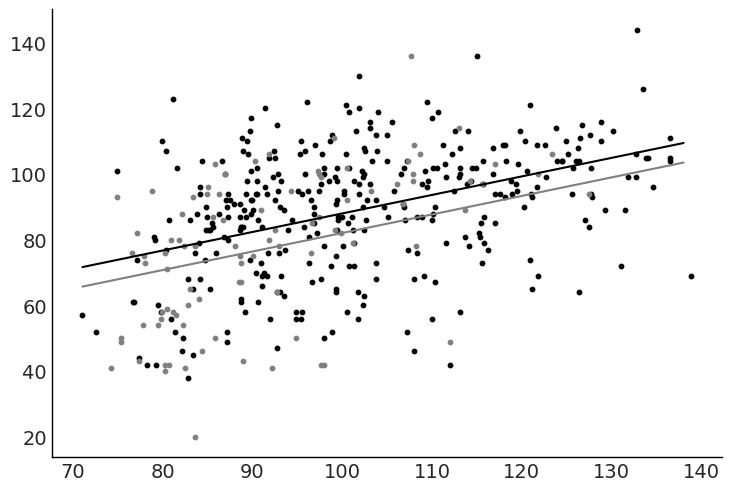

In [9]:
stats_3 = az.summary(idata_3, kind="stats")["mean"]
x = np.arange(kidiq["mom_iq"].min(), kidiq["mom_iq"].max())
y_pred_mom_hs_1 = stats_3["Intercept"] + stats_3["mom_hs"] + stats_3["mom_iq"] * x
y_pred_mom_hs_0 = stats_3["Intercept"] + stats_3["mom_iq"] * x

fig, ax = plt.subplots()
ax.scatter("mom_iq", "kid_score", data=kidiq.query("mom_hs == 1"), color="black", s=10)
ax.scatter("mom_iq", "kid_score", data=kidiq.query("mom_hs == 0"), color="gray", s=10)
ax.plot(x, y_pred_mom_hs_1, color="black")
ax.plot(x, y_pred_mom_hs_0, color="gray")

### Two fitted regression lines -- model with interaction

In [10]:
model_4 = bmb.Model("kid_score ~ mom_hs + mom_iq + mom_hs:mom_iq", data=kidiq)
idata_4 = model_4.fit()
az.summary(idata_4, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kid_score_sigma, Intercept, mom_hs:mom_iq, mom_iq, mom_hs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,-9.671,13.954,-35.952,16.048
mom_hs,49.183,15.520,21.813,79.798
mom_iq,0.949,0.151,0.665,1.227
mom_hs:mom_iq,-0.462,0.164,-0.764,-0.154
kid_score_sigma,18.000,0.617,16.815,19.118


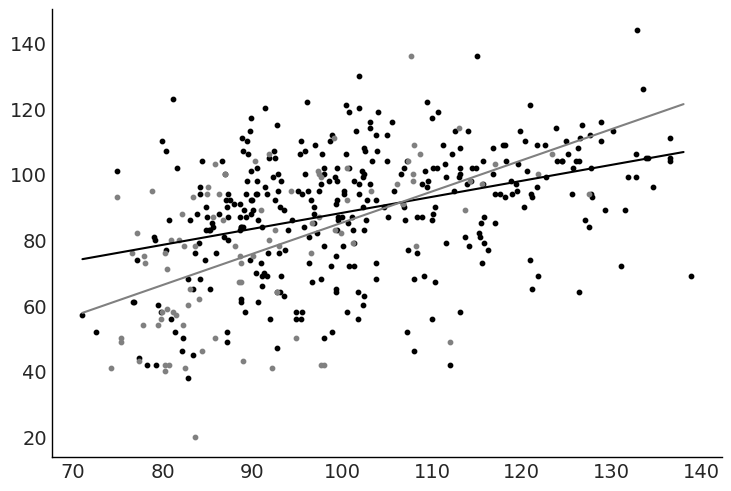

In [11]:
stats_4 = az.summary(idata_4, kind="stats")["mean"]
x = np.arange(kidiq["mom_iq"].min(), kidiq["mom_iq"].max())
y_pred_mom_hs_1 = (
    stats_4["Intercept"]
    + stats_4["mom_hs"]
    + (stats_4["mom_hs:mom_iq"] + stats_4["mom_iq"]) * x
)
y_pred_mom_hs_0 = stats_4["Intercept"] + stats_4["mom_iq"] * x

fig, ax = plt.subplots()
ax.scatter("mom_iq", "kid_score", data=kidiq.query("mom_hs == 1"), color="black", s=10)
ax.scatter("mom_iq", "kid_score", data=kidiq.query("mom_hs == 0"), color="gray", s=10)
ax.plot(x, y_pred_mom_hs_1, color="black")
ax.plot(x, y_pred_mom_hs_0, color="gray");

## Displaying uncertainty in the fitted regression
### A single continuous predictor

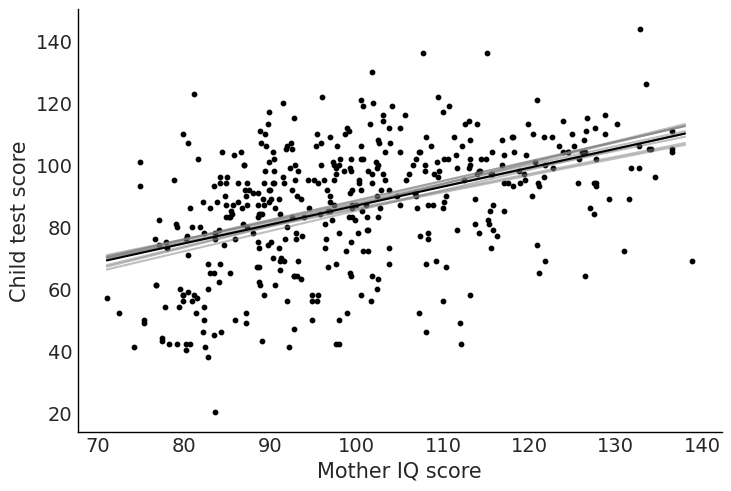

In [13]:
index = rng.choice(len(idata_2.posterior["draw"].values), 10)
intercept_sample = idata_2.posterior["Intercept"][0, index].values
slope_sample = idata_2.posterior["mom_iq"][0, index].values
x = np.arange(kidiq["mom_iq"].min(), kidiq["mom_iq"].max())
y_pred = (
    idata_2.posterior["Intercept"].values.mean()
    + idata_2.posterior["mom_iq"].values.mean() * x
)

fig, ax = plt.subplots()
ax.scatter("mom_iq", "kid_score", data=kidiq, color="black", s=10)
for intercept, slope in zip(intercept_sample, slope_sample):
    ax.plot(x, intercept + slope * x, color="gray", alpha=0.5)
ax.plot(x, y_pred, color="black")

ax.set_xlabel("Mother IQ score")
ax.set_ylabel("Child test score");

### Two predictors

In [14]:
# TODO: add plot code here

### Center predictors to have zero mean

In [15]:
kidiq["c_mom_hs"] = kidiq["mom_hs"] - kidiq["mom_hs"].mean()
kidiq["c_mom_iq"] = kidiq["mom_iq"] - kidiq["mom_iq"].mean()
model_4c = bmb.Model(
    "kid_score ~ c_mom_hs + c_mom_iq + c_mom_hs:c_mom_iq",
    data=kidiq,
)
idata_4c = model_4c.fit()
az.summary(idata_4c)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kid_score_sigma, Intercept, c_mom_hs:c_mom_iq, c_mom_iq, c_mom_hs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,87.640,0.912,85.894,89.346,0.014,0.010,4003.0,3038.0,1.0
c_mom_hs,2.755,2.368,-1.498,7.267,0.040,0.029,3415.0,2573.0,1.0
c_mom_iq,0.590,0.061,0.479,0.705,0.001,0.001,4810.0,3095.0,1.0
c_mom_hs:c_mom_iq,-0.485,0.159,-0.772,-0.175,0.002,0.002,4816.0,3545.0,1.0
kid_score_sigma,18.002,0.605,16.930,19.136,0.008,0.006,5254.0,3572.0,1.0


### Center predictors based on a reference point

In [16]:
kidiq["c2_mom_hs"] = kidiq["mom_hs"] - 0.5
kidiq["c2_mom_iq"] = kidiq["mom_iq"] - 100
model_4c2 = bmb.Model(
    "kid_score ~ c2_mom_hs + c2_mom_iq + c2_mom_hs:c2_mom_iq",
    data=kidiq,
)
idata_4c2 = model_4c2.fit()
az.summary(idata_4c2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kid_score_sigma, Intercept, c2_mom_hs:c2_mom_iq, c2_mom_iq, c2_mom_hs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,86.818,1.210,84.457,88.981,0.025,0.017,2387.0,2341.0,1.0
c2_mom_hs,2.883,2.386,-1.652,7.248,0.049,0.035,2381.0,2572.0,1.0
c2_mom_iq,0.726,0.082,0.582,0.888,0.002,0.001,2074.0,2479.0,1.0
c2_mom_hs:c2_mom_iq,-0.482,0.163,-0.799,-0.188,0.003,0.002,2172.0,2444.0,1.0
kid_score_sigma,18.000,0.619,16.896,19.269,0.010,0.007,3772.0,3164.0,1.0


### Center and scale predictors to have zero mean and sd=1/2

In [17]:
kidiq["z_mom_hs"] = (kidiq["mom_hs"] - kidiq["mom_hs"].mean()) / (
    2 * kidiq["mom_hs"].std()
)
kidiq["z_mom_iq"] = (kidiq["mom_iq"] - kidiq["mom_iq"].mean()) / (
    2 * kidiq["mom_iq"].std()
)
model_4c = bmb.Model(
    "kid_score ~ z_mom_hs + z_mom_iq + z_mom_hs:z_mom_iq",
    data=kidiq,
)
idata_4c = model_4c.fit()
az.summary(idata_4c)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kid_score_sigma, Intercept, z_mom_hs:z_mom_iq, z_mom_iq, z_mom_hs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,87.648,0.937,85.868,89.388,0.012,0.009,6013.0,3314.0,1.0
z_mom_hs,2.299,2.018,-1.590,6.002,0.034,0.025,3598.0,3456.0,1.0
z_mom_iq,17.676,1.846,14.433,21.301,0.027,0.019,4519.0,3154.0,1.0
z_mom_hs:z_mom_iq,-12.069,3.996,-19.596,-4.583,0.064,0.047,3939.0,3062.0,1.0
kid_score_sigma,18.002,0.616,16.880,19.145,0.009,0.006,5097.0,3149.0,1.0


### Predict using working status of mother

In [18]:
model_5 = bmb.Model("kid_score ~ C(mom_work)", data=kidiq)
idata_5 = model_5.fit()
az.summary(idata_5, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kid_score_sigma, Intercept, C(mom_work)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,81.994,2.292,77.896,86.441
C(mom_work)[2],3.866,3.090,-1.804,9.844
C(mom_work)[3],11.504,3.561,4.844,18.084
C(mom_work)[4],5.213,2.672,-0.025,9.851
kid_score_sigma,20.289,0.696,19.009,21.646
